#tensorflow=2.6 cuda=11.2 RTX4060

In [1]:
import pandas as pd
import re
import os
import jieba
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,SimpleRNN, Dense, SpatialDropout1D, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
file_path ="D:\\big_data_R\\ptt-stock20240604.csv"
df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,title,title_id,time,content,push_id,push_content,push_time
0,0,[新聞] 魏哲家霸氣喊「台積電無敵手」 擴廠連,keel90135 (尼可),Tue Jun 4 15:55:30 2024,原文標題：魏哲家霸氣喊「台積電無敵手」 擴廠連說3次台灣原文連結：https://finan...,xiaoyao,已知利多 我阿嬤都知道,06/04 15:57
1,1,[新聞] 魏哲家霸氣喊「台積電無敵手」 擴廠連,keel90135 (尼可),Tue Jun 4 15:55:30 2024,原文標題：魏哲家霸氣喊「台積電無敵手」 擴廠連說3次台灣原文連結：https://finan...,strlen,尼這樣 美國老大哥又不高興惹,06/04 15:58
2,2,[新聞] 魏哲家霸氣喊「台積電無敵手」 擴廠連,keel90135 (尼可),Tue Jun 4 15:55:30 2024,原文標題：魏哲家霸氣喊「台積電無敵手」 擴廠連說3次台灣原文連結：https://finan...,chinaeatshit,不說台灣明天就跌停了 說台灣又是預料中 簡單的說,06/04 15:58
3,3,[新聞] 魏哲家霸氣喊「台積電無敵手」 擴廠連,keel90135 (尼可),Tue Jun 4 15:55:30 2024,原文標題：魏哲家霸氣喊「台積電無敵手」 擴廠連說3次台灣原文連結：https://finan...,chinaeatshit,就是沒有利多,06/04 15:58
4,4,[新聞] 魏哲家霸氣喊「台積電無敵手」 擴廠連,keel90135 (尼可),Tue Jun 4 15:55:30 2024,原文標題：魏哲家霸氣喊「台積電無敵手」 擴廠連說3次台灣原文連結：https://finan...,ccdrv,已反應 全世界都知道,06/04 15:58


In [3]:
def remove_number(text):
    return re.sub(r'[0-9.]', '', text)
df['push_content']=df['push_content'].apply(remove_number)

In [4]:
#remove url
webs=[]
for i in df['push_content']:
    website=re.findall(r"http[s]?://[^\s]+",i)
    if len(website)>0:
        webs.append(website)
        
for j in webs:
    df['push_content']=df['push_content'].replace(j,"")

In [5]:
df=df.dropna(axis=0,how='any',thresh=None,subset=None,inplace=False)
print(df.isnull().sum())

Unnamed: 0      0
title           0
title_id        0
time            0
content         0
push_id         0
push_content    0
push_time       0
dtype: int64


In [6]:
positive_words = ['賺爛','利多','月增','年增','穩穩','穩','厲害','推','降息','轉虧為盈','減少成本','成本減少','跳空','多賺','發大財','有前景',
                  '盈利','利好','強勁','繁榮','讚','無敵','霸氣','噴','加碼','猛','順差','買超','牛市','潛力股','創新高','GG','台積','贏','發了',
                  '強勢','熱點','大漲','增量','看漲','超額收益','穩賺','高成長','推','降息','漲','ai','amd','nvidia','AI',"AMD",'NVIDIA']

middle_words = ['投資','收益','獲利','份額','營收','市場','業績','需求','進步','效率','生產','財務','股息','銷售','業績','預期',
                '回報','風險','收益率','成長','回報','利潤','市值','經濟','消息','預期','利']

positive_degree=['增加','提升','更多','上升','飆升','提高','改善','強勁','增長','擴展','看好','好','超額','無限']

negative_degree=['減少','下降','放緩','面臨','低迷','不明','停滯','不佳','衰退','下滑','跌','壞','低','不如','沒有']

negative_words = ['韭菜','缺電','升息','出貨','跌停','gg','月減','年減','破產','高失業','高通貨膨脹','雷','崩潰','崩盤','利多出盡','空頭',
                  '跌破','中國','跌到','拉回','停損','賺不到','不會賺','跌爛','大跌','散戶','崩','暴跌','跌幅','套','殺','悲','穩死',
                  '跳水','賣超','倒','哭','完蛋','回檔','衰','賠','虧損','下挫','貶值','裁員','魯蛇','破產','重組','減產','爛死', 
                  '經濟衰退','債務','虧本','虧空','失敗','損失','赤字','退市','笑死','違約','緊縮','利空','qq','慘','折損','沒賺到','賣',
                  '萎縮','撤資','震盪','惡化','失敗','困難','賣壓','下去','xd','制裁','沒有利多','怕','QQ','別買','XD','臭','隱憂','小心']

In [7]:
def classify_sentence(sentence):
    # 尋找負面形容詞和中立詞語同時出現
    if any(neg_word in sentence for neg_word in negative_degree):
        if any(mid_word in sentence for mid_word in middle_words):
            return 'negative'
    
    # 尋找負面詞語
    if any(word in sentence for word in negative_words):
        return 'negative'
    
    # 尋找正面詞語
    if any(word in sentence for word in positive_words):
        return 'positive'
    
    # 尋找正面形容詞和中立詞語同時出現
    if any(pos_word in sentence for pos_word in positive_degree):
        if any(mid_word in sentence for mid_word in middle_words):
            return 'positive'
    
    
    return None  # If no match

In [8]:
# 應用情感標籤函數並生成sentiment列
df['sentiment'] = df['push_content'].apply(classify_sentence)
# 只保留正向和負向的標籤
df = df[df['sentiment'].notnull()]
print('回文數目（全部）：%d' % df.shape[0])
print('回文數目（正面）：%d' % df[df.sentiment=='positive'].shape[0])
print('回文數目（負面）：%d' % df[df.sentiment=='negative'].shape[0])

回文數目（全部）：4124
回文數目（正面）：1955
回文數目（負面）：2169


In [9]:
stop_words=[]
with open("C:\\Users\\user\\Downloads\\cn_stopwords_1.txt", 'r', encoding='utf8') as f:
    stop_words = f.read().split('\n') 
stop_words.append('\n')
def remove_stopwords(text):
    words = jieba.lcut(text)
    return ' '.join([word for word in words if word not in stop_words])
df['content_cut']=df['push_content'].apply(remove_stopwords)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.cache
Loading model cost 0.832 seconds.
Prefix dict has been built successfully.


In [10]:
# 文本向量化
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['content_cut'])
sequences = tokenizer.texts_to_sequences(df['content_cut'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
max_sequence_length = 50
data = pad_sequences(sequences, maxlen=max_sequence_length)

Found 6871 unique tokens.


In [11]:
# 將標籤轉換為數字格式
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['sentiment'])
labels = to_categorical(np.asarray(labels))
# 分割數據集為訓練集和測試集
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42,shuffle=True)

In [12]:
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=max_sequence_length))
model.add(Bidirectional(SimpleRNN(128, dropout=0.1,recurrent_dropout=0.1)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(np.unique(labels)), activation='softmax'))
print(model.summary())
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           687200    
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               58624     
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 762,402
Trainable params: 762,402
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
# 使用EarlyStopping回調來防止過擬合
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# 訓練模型
epochs = 15  # 增加訓練次數
batch_size = 256

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), verbose=2, callbacks=[early_stopping])

Epoch 1/15
13/13 - 8s - loss: 0.7059 - accuracy: 0.5259 - val_loss: 0.6854 - val_accuracy: 0.5891
Epoch 2/15
13/13 - 4s - loss: 0.6912 - accuracy: 0.5344 - val_loss: 0.6812 - val_accuracy: 0.5248
Epoch 3/15
13/13 - 4s - loss: 0.6707 - accuracy: 0.5753 - val_loss: 0.6751 - val_accuracy: 0.5430
Epoch 4/15
13/13 - 4s - loss: 0.5921 - accuracy: 0.6881 - val_loss: 0.5212 - val_accuracy: 0.7430
Epoch 5/15
13/13 - 4s - loss: 0.3758 - accuracy: 0.8466 - val_loss: 0.3032 - val_accuracy: 0.8788
Epoch 6/15
13/13 - 4s - loss: 0.1489 - accuracy: 0.9506 - val_loss: 0.3165 - val_accuracy: 0.8788
Epoch 7/15
13/13 - 4s - loss: 0.0799 - accuracy: 0.9727 - val_loss: 0.3872 - val_accuracy: 0.8667
Epoch 8/15
13/13 - 4s - loss: 0.0560 - accuracy: 0.9803 - val_loss: 0.4163 - val_accuracy: 0.8703


In [14]:
def show_train_history(train_history,train,validation,title):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('train history')
    plt.ylabel(title)
    plt.xlabel('epoch')
    plt.legend(['train','validation'])
    plt.show()

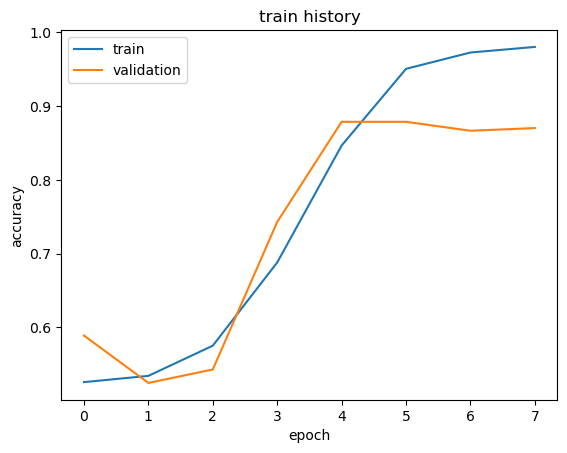

In [15]:
show_train_history(history,'accuracy','val_accuracy','accuracy')

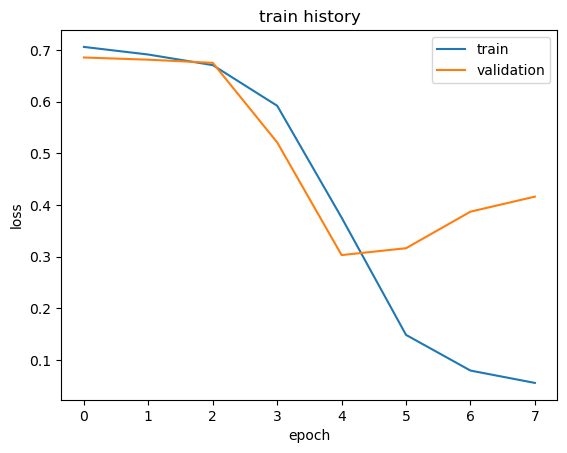

In [16]:
show_train_history(history,'loss','val_loss','loss')

In [17]:
model.evaluate(x_test,y_test)

26/26 [==============================] - 1s 26ms/step - loss: 0.3032 - accuracy: 0.8788


[0.30323347449302673, 0.8787878751754761]

In [18]:
test_texts = [
    "這家公司最近業績提升，股價上漲",
    "經濟衰退導致市場低迷，投資者損失慘重",
    "市場份額增加，銷售創新高",
    "公司破產重組，裁員大幅增加",
    "新的投資計劃將帶來更多收益",
    "市場需求減少，營收下降",
    "創新技術提高了生產效率",
    "由於貿易戰，企業面臨巨大風險",
    "公司宣布派發高額股息",
    "供應鏈問題導致生產停滯",
    "企業獲得政府補貼，財務狀況改善",
    "高失業率影響消費者信心",
    "新產品發布，市場反應熱烈",
    "全球經濟放緩，市場前景不明",
    "公司擴展到新市場，預期收益增長",
    "高通貨膨脹壓力持續存在",
    "企業進行大規模重組，預計減少成本",
    "公司成功收購競爭對手，市場份額上升",
    "債務問題加劇，企業面臨破產風險",
    "營業額增長超出預期，股價飆升"
]
test =pd.DataFrame(test_texts,columns=['test_texts'])
test['assign_sentiment']=test.test_texts.apply(classify_sentence)
test=test.dropna()
test

,test_texts,assign_sentiment
0,這家公司最近業績提升，股價上漲,positive
1,經濟衰退導致市場低迷，投資者損失慘重,negative
2,市場份額增加，銷售創新高,positive
3,公司破產重組，裁員大幅增加,negative
4,新的投資計劃將帶來更多收益,positive
5,市場需求減少，營收下降,negative
6,創新技術提高了生產效率,positive
7,由於貿易戰，企業面臨巨大風險,negative
9,供應鏈問題導致生產停滯,negative
10,企業獲得政府補貼，財務狀況改善,positive


In [19]:
test.test_texts =test.test_texts.apply(remove_stopwords)
pred_label2= label_encoder.fit_transform(test['assign_sentiment'])
pred_label2 = to_categorical(np.asarray(pred_label2))
tokenizer.fit_on_texts(test.test_texts)
sequences2 = tokenizer.texts_to_sequences(test.test_texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
max_sequence_length = 50
data2 = pad_sequences(sequences2, maxlen=max_sequence_length)

Found 6899 unique tokens.


In [20]:
pred=model.predict(data2)
y_pred_class = np.argmax(np.array(pred), axis=1)
y_pred_label = np.argmax(np.array(pred_label2), axis=1)
from sklearn.metrics import classification_report
print(classification_report(y_pred_label,y_pred_class))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.62      0.62      0.62         8

    accuracy                           0.67        18
   macro avg       0.66      0.66      0.66        18
weighted avg       0.67      0.67      0.67        18

